#### Import Libaries


In [1]:
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

#### Load Data

In [2]:
# Load the datasets
dfengagement = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')
dfusers = pd.read_csv('takehome_users.csv', encoding='latin-1')


In [3]:
dfengagement.head(5)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
dfusers.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


#### Explore and Clean Data

In [5]:
dfengagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
dfusers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Fix Data Types:</br>
Engagment dataset :overt Object to DataTime on  time_stamp column 
Users dataset :Covert Object to DataTime on creation_time and last_session_creation_time columns

In [7]:
dfengagement['time_stamp'] = pd.to_datetime(dfengagement['time_stamp'])

In [8]:
dfusers['creation_time'] = pd.to_datetime(dfusers['creation_time'])
dfusers['last_session_creation_time'] = pd.to_datetime(dfusers['last_session_creation_time'], unit='s')

Check if any missing data in both dataset

In [9]:
missing_values_engagement = dfengagement.isnull().sum()
print(missing_values_engagement)

time_stamp    0
user_id       0
visited       0
dtype: int64


NO missing data in engagment data

In [10]:
missing_values_users = dfusers.isnull().sum()
print(missing_values_users)

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64


There are missing values in two columns:</br>
last_session_creation_time: 3,177 missing values, indicating users who may not have logged in after account creation.</br>
invited_by_user_id: 5,583 missing values, which is expected as not all users were invited by another user.</br>

Lets update last_session_creation_time as account_creation_time for those missing data.

In [11]:
dfusers.loc[dfusers['last_session_creation_time'].isnull(), 'last_session_creation_time'] = dfusers['creation_time']

In [12]:
missing_values_users = dfusers.isnull().sum()
print(missing_values_users)

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64


### Data Analysis

<b>Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven day  period</b>

In [13]:
dfengagement['visited'].unique()

array([1])

In [14]:
dfengagment_groupbyWeek = dfengagement.set_index('time_stamp')

dfengagement_groupbyWeek = dfengagement.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W')])['visited'].sum().reset_index()

dfengagement_groupbyWeek.head()

,user_id,time_stamp,visited
0,1,2014-04-27,1
1,2,2013-11-17,1
2,2,2013-12-01,1
3,2,2013-12-15,1
4,2,2013-12-29,1


In [15]:
adoptedusers = dfengagement_groupbyWeek[dfengagement_groupbyWeek.visited >= 3]
adoptedusers = adoptedusers.drop_duplicates(subset='user_id', keep="first")
adoptedusers.head()

,user_id,time_stamp,visited
7,2,2014-02-09,3
23,10,2013-03-03,3
96,20,2014-03-16,3
110,33,2014-03-23,3
126,42,2012-12-30,4


In [16]:
adopted = adoptedusers.user_id.values
dfusers["is_adopted"] = dfusers.object_id.apply(lambda u_id: 1 if u_id in adopted else 0)

In [17]:
dfusers[dfusers["is_adopted"]==0]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,0


In [18]:
dfusers[dfusers["is_adopted"]==1]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0,1
19,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,2014-05-29 11:46:38,0,0,58,NaN,1
32,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,2014-05-31 06:29:09,0,0,401,79.0,1
41,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,2014-05-25 19:05:07,1,0,235,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
11964,11965,2014-04-25 07:17:35,Storey Lewis,LewisStorey@cuvox.de,GUEST_INVITE,2014-05-21 07:17:35,0,0,65,11251.0,1
11966,11967,2014-01-12 08:12:37,Barbosa Pedro,PedroFernandesBarbosa@gmail.com,GUEST_INVITE,2014-05-31 08:12:37,0,0,15,5688.0,1
11968,11969,2013-06-01 00:48:14,Dickinson Aidan,AidanDickinson@hotmail.com,GUEST_INVITE,2014-05-30 00:48:14,1,1,52,6647.0,1
11974,11975,2013-03-23 11:10:11,Daecher Jürgen,JurgenDaecher@gustr.com,GUEST_INVITE,2014-05-22 11:10:11,1,0,31,6410.0,1


<b>Identify  which  factors  predict  future  user adoption.</b>

##### Adoption Rate Data Distribution

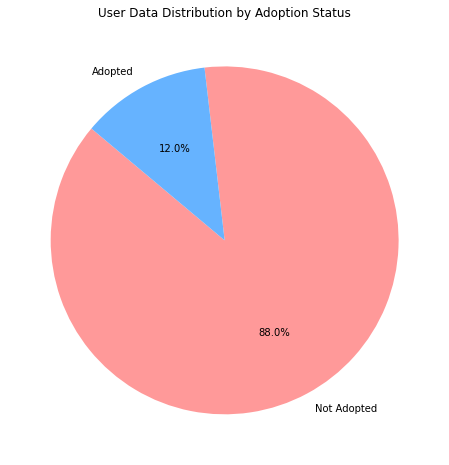

In [19]:
adopted_distribution = dfusers['is_adopted'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(adopted_distribution, labels=['Not Adopted', 'Adopted'], autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('User Data Distribution by Adoption Status')
plt.show()

<b>Identify  which  factors  predict  future  user
adoption</b>

First, lets do lable encoding for those object category columns

In [20]:
dfuserscor = dfusers.copy()

In [21]:


le = LabelEncoder()
for column in dfuserscor.select_dtypes(include=['object']).columns:
    dfuserscor[column] = le.fit_transform(dfuserscor[column])

In [22]:
dfuserscor

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted
0,1,2014-04-22 03:53:30,2087,1047,0,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,8488,7290,1,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,1259,7681,1,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,2099,7971,0,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,8708,3718,0,2013-01-22 10:14:20,0,0,193,5240.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,7156,9573,1,2013-09-06 06:14:15,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,3521,535,4,2013-01-15 18:28:37,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,4598,4322,0,2014-04-27 12:45:16,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,3261,11341,2,2012-06-02 11:55:59,0,0,6,NaN,0


In [23]:
correlation_matrix = dfuserscor.corr()['is_adopted'].sort_values()

In [24]:
correlation_matrix

name                         -0.002182
creation_source              -0.001549
invited_by_user_id            0.000356
email                         0.002309
enabled_for_marketing_drip    0.005901
object_id                     0.007481
opted_in_to_mailing_list      0.010339
org_id                        0.060683
is_adopted                    1.000000
Name: is_adopted, dtype: float64

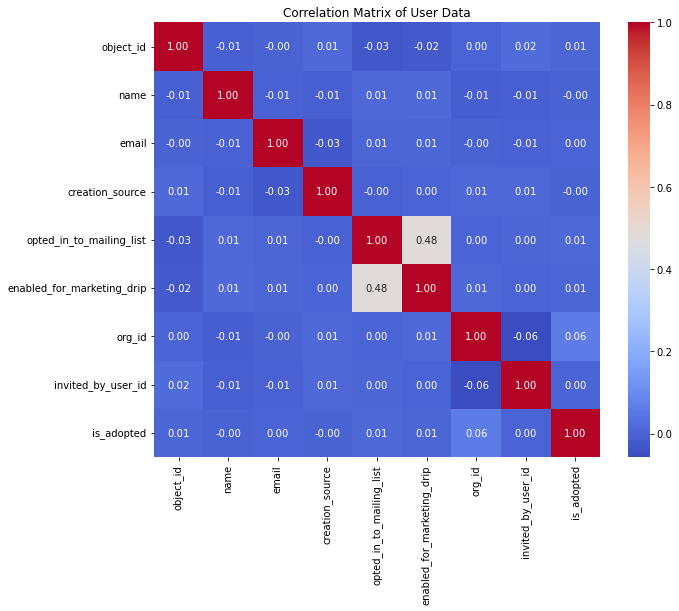

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(dfuserscor.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of User Data')
plt.show()

Above Correlation matrix shows org_id,enabled_for_marketing_drip , opted_in_to_mailing list and Creation Source are somewhat correalted with adopted or not adopted event though number are not significate.</br>
Hence, Key factors to explore include:
</br>
Organization ID: The organization the user belongs to, which might indicate network effects.</br>
Opted into Mailing List: Whether the user has opted into receiving marketing emails.</br>
Enabled for Marketing Drip: Whether the user is on the regular marketing email drip.</br>
Creation Source: How the user's account was created (e.g., personal projects, guest invite, etc.).</br>

In [26]:
org_adoption = dfusers.groupby('org_id')['is_adopted'].agg(['mean', 'count']).sort_values(by='mean', ascending=False).head(20)
mailing_list_adoption = dfusers.groupby('opted_in_to_mailing_list')['is_adopted'].agg(['mean', 'count'])
marketing_drip_adoption = dfusers.groupby('enabled_for_marketing_drip')['is_adopted'].agg(['mean', 'count'])
creation_source_adoption = dfusers.groupby('creation_source')['is_adopted'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

##### Top 20 Organizational Network Effects on User Adoption

In [27]:
org_adoption

,mean,count
org_id,,
387,0.500000,12
235,0.461538,13
270,0.428571,14
399,0.384615,13
415,0.375000,16
400,0.375000,8
345,0.357143,14
318,0.352941,17
161,0.333333,21


Top 3 Highest Adption Rate </br>
Organization 387: Achieves a 50% adoption rate with 12 members.</br>
Organization 235: Records a 46.15% adoption rate with 13 members.</br>
Organization 270: Posts a 42.86% adoption rate with 14 members.</br>
The variation in adoption rates among organizations can be attributed to organizational culture, project nature, and the effectiveness of internal promotions and invitations.</br>

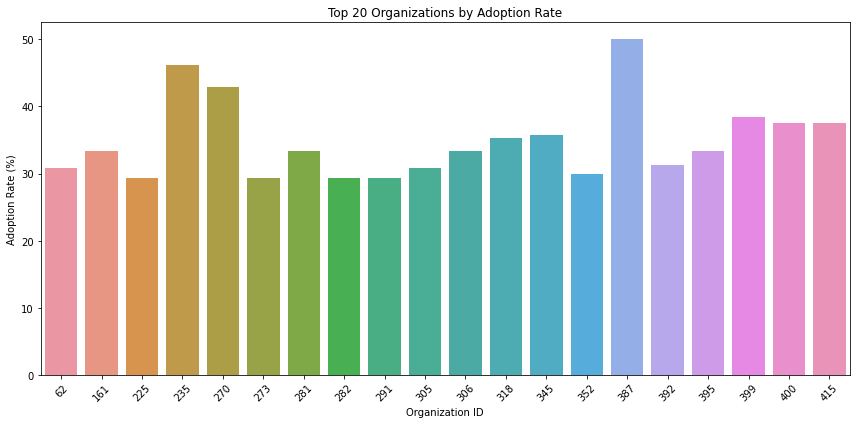

In [28]:

plt.figure(figsize=(12, 6))
sns.barplot(x=org_adoption.index, y=org_adoption['mean'] * 100)
plt.title('Top 20 Organizations by Adoption Rate')
plt.ylabel('Adoption Rate (%)')
plt.xlabel('Organization ID')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



##### Marketing Engagement  and Mailing List Impact on User Adoption

In [29]:
marketing_drip_adoption

,mean,count
enabled_for_marketing_drip,,
0,0.119612,10208
1,0.125000,1792


In [30]:
mailing_list_adoption

,mean,count
opted_in_to_mailing_list,,
0,0.118477,9006
1,0.126253,2994


Users engaged in regular marketing email drips also exhibit a slightly higher adoption rate of 12.50%, compared to non-participants at 11.96%.
Users who opted into marketing emails show a marginally higher adoption rate of 12.63%, versus those who didn't at 11.85%.

This data indicates a subtle positive effect of marketing engagement, via mailing lists and marketing drips, on user adoption, albeit with a relatively small effect size.

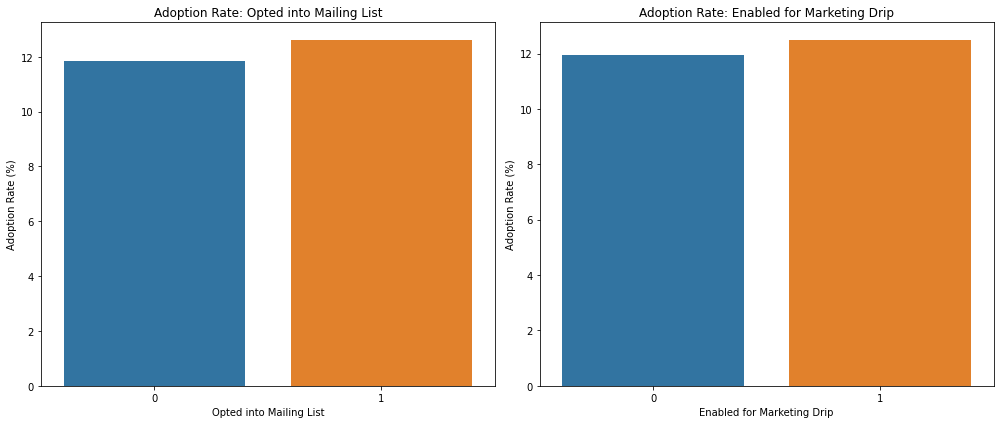

In [31]:
# Visualization for Marketing Engagement Impact on User Adoption
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=mailing_list_adoption.index, y=mailing_list_adoption['mean'] * 100, ax=ax[0])
ax[0].set_title('Adoption Rate: Opted into Mailing List')
ax[0].set_ylabel('Adoption Rate (%)')
ax[0].set_xlabel('Opted into Mailing List')

sns.barplot(x=marketing_drip_adoption.index, y=marketing_drip_adoption['mean'] * 100, ax=ax[1])
ax[1].set_title('Adoption Rate: Enabled for Marketing Drip')
ax[1].set_ylabel('Adoption Rate (%)')
ax[1].set_xlabel('Enabled for Marketing Drip')


plt.tight_layout()
plt.show()

#####  Creation Source Impact on User Adoption

In [32]:
creation_source_adoption

,mean,count
creation_source,,
GUEST_INVITE,0.150717,2163
SIGNUP_GOOGLE_AUTH,0.148736,1385
SIGNUP,0.131768,2087
ORG_INVITE,0.115421,4254
PERSONAL_PROJECTS,0.069635,2111


Guest Invite: 15.07% adoption</br>
Signup Google Auth: 14.87% adoption</br>
Direct Signup: 13.18% adoption</br>
Org Invite: 11.54% adoption</br>
Personal Projects: 6.96% adoption</br>
Invitations (personal workspace or organization) lead to higher adoption rates than individual signups, highlighting the role of social connections in user engagement.
</br>

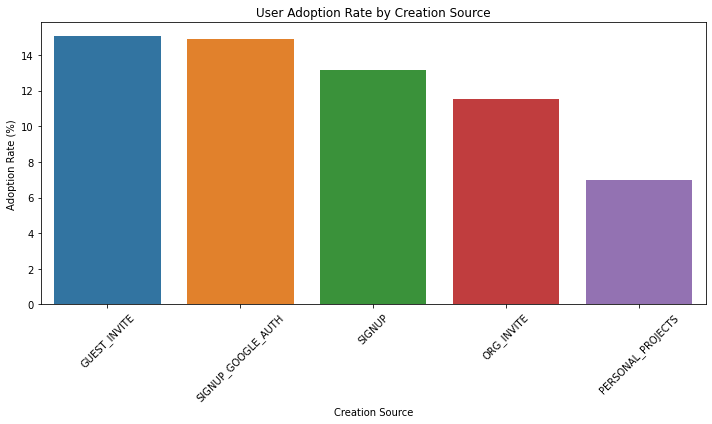

In [33]:

plt.figure(figsize=(10, 6))
sns.barplot(x=creation_source_adoption.index, y=creation_source_adoption['mean'] * 100)
plt.title('User Adoption Rate by Creation Source')
plt.ylabel('Adoption Rate (%)')
plt.xlabel('Creation Source')
plt.xticks(rotation=45)
plt.tight_layout()

#### Conclusion

Above investigation suggests that when users invite others or sign up through Google Auth, they’re more likely to stick around. So, encouraging a bit of the "invite a friend" spirit could really help boost those adoption numbers.
Secondly,targeted emails and marketing campaigns seems to make a slight but positive difference in getting users to engage more. It’s all about reaching out in the right way.
Lasly,there’s something special about organizations with high adoption rates. Digging into what makes them tick could reveal some golden strategies to help spread that adoption magic across the board.